In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

import sys, os, gc, math
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from scipy.fftpack import dct,idct


sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *


#Seed used for choosing classes, training points, and test points.
#SEED = 14
SEED=11

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Define params of model
input_shape = (32,32,3)
num_classes = 10

In [3]:
#%%capture one
#Load model from disk
model_name = 'cifar10-resnet'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='cifar10', transform='dct-3d',seed=SEED)
print ('Total Model Params: %d' % model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 200
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)    

../models/neural_network.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  x_rec[i,:,:,0]= f_recon_r
../models/neural_network.py:173: ComplexWarning: Casting complex values to real discards the imaginary part
  x_rec[i,:,:,1]= f_recon_g
../models/neural_network.py:174: ComplexWarning: Casting complex values to real discards the imaginary part
  x_rec[i,:,:,2]= f_recon_b


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Learning rate:  0.001
Total Model Params: 273066
Loaded model from disk


In [14]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.val_data, model.val_labels)[1]))

10000/10000 [==============================] - 3s 286us/step
Model Accuracy: 0.82800


In [4]:
%%capture two
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=int(model.train_data.shape[0]/2), high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

**GREYBOX ATTACKS**

In [5]:
%%capture three
num_test_samples_per_class = 100
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

In [ ]:
%%capture four
import time
#Get Regular, JSMA, DF, and CW test points
reg_data = model.test_data[test_indices]
start_time = time.time()
jsma_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='JSMA', iterations=100)
print("--- JSMA: %s seconds ---" % (time.time() - start_time))
start_time = time.time()
cwl0_data = model.generate_perturbed_data(model.test_data[test_indices], seed=SEED, perturbation='CW-l0')
print("--- CW: %s seconds ---" % (time.time() - start_time))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
#%%capture five
reg_data = np.load('data/reg_data_cifar10_l0.npy')
jsma_data = np.load('data/jsma_data_cifar10_l0.npy')
cwl0_data = np.load('data/cwl0_data_cifar10_l0.npy')


In [ ]:
%%capture five
np.save('data/reg_data_cifar10_l0', reg_data)
#np.save('data/jsma_data_cifar10_l0', jsma_data)
np.save('data/cwl0_data_cifar10_l0', cwl0_data)

In [26]:
%%capture six
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='cifar10',transform='dct-3d', seed=SEED)
model.load_model(model_save_path, weights_save_path)    

TypeError: super(type, obj): obj must be an instance or subtype of type

In [17]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy CW-l0: %.5f' % (model.model.evaluate(cwl0_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy JSMA: %.5f' % (model.model.evaluate(jsma_data,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 0s 170us/step
Model Accuracy REG: 0.87800
1000/1000 [==============================] - 0s 162us/step
Model Accuracy CW-l0: 0.29300
1000/1000 [==============================] - 0s 164us/step
Model Accuracy JSMA: 0.01500


Training Data: 


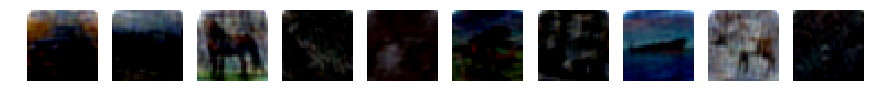

In [7]:
#Lets visualize training data
x_vis = np.random.choice(range(0,num_train_samples), 10)
print ('Training Data: ')
visualize(train_data[x_vis].reshape(-1,*input_shape), 10, '../figures/train-cifar10_l0')

Regular: 


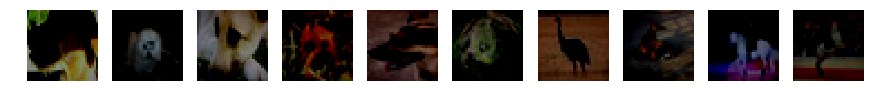

CW-l0: 


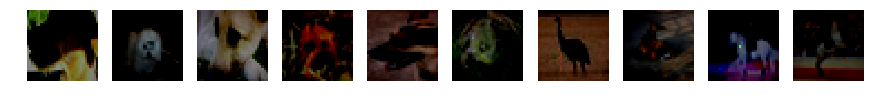

JSMA: 


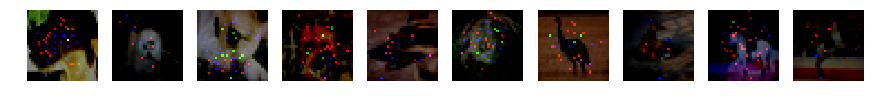

In [8]:
#Lets visualize samples from each attack
x_vis = np.random.choice(range(0,num_test_samples), 10)
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-cifar10_l0')
print ('CW-l0: ')
visualize(cwl0_data[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl0-cifar10_l0')
print ('JSMA: ')
visualize(jsma_data[x_vis].reshape(-1,*input_shape), 10, '../figures/jsma-cifar10_l0')

In [9]:
%%capture seven
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
cwl0_preds = model.model.predict(cwl0_data.reshape(-1,*input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,*input_shape))

#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
cwl0_labels = preds_to_labels(cwl0_preds)
jsma_labels = preds_to_labels(jsma_preds)

#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
cwl0_idx = np.where(np.argmax(cwl0_preds, axis=1) != true_preds)[0]
jsma_idx = np.where(np.argmax(jsma_preds, axis=1) != true_preds)[0]


#Filter data points to be used for similarity
cwl0_data_fil = cwl0_data[cwl0_idx]
jsma_data_fil = jsma_data[jsma_idx]


#Filter labels to be used
cwl0_labels_fil = cwl0_labels[cwl0_idx]
jsma_labels_fil = jsma_labels[jsma_idx]

In [10]:
#Get l-0 distortion 
print ('CW-l0: %.5f' % (avg_l0_dist(reg_data[cwl0_idx], cwl0_data_fil)))
print ('JSMA: %.5f' % (avg_l0_dist(reg_data[jsma_idx], jsma_data_fil)))

CW-l0: 1279.00000
JSMA: 35.00000


In [14]:
n = 32
k=75

In [15]:
clean_reg = np.zeros(reg_data.shape)
for i in range(num_test_samples):
    f_x_r = dct(reg_data[i,:,:,0].flatten(),norm='ortho').reshape(int(n),int(n))
    f_x_g = dct(reg_data[i,:,:,1].flatten(),norm='ortho').reshape(int(n),int(n))
    f_x_b = dct(reg_data[i,:,:,2].flatten(),norm='ortho').reshape(int(n),int(n))
    top_k_r = get_top_k(f_x_r,k=k)
    top_k_g = get_top_k(f_x_g,k=k)
    top_k_b = get_top_k(f_x_b,k=k)
    f_recon_r = idct(top_k_r.flatten(),norm='ortho').reshape(int(n),int(n))
    f_recon_g = idct(top_k_g.flatten(),norm='ortho').reshape(int(n),int(n))
    f_recon_b = idct(top_k_b.flatten(),norm='ortho').reshape(int(n),int(n))
  
    clean_reg[i,:,:,0]= f_recon_r
    clean_reg[i,:,:,1]= f_recon_g
    clean_reg[i,:,:,2]= f_recon_b

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


In [16]:
avg=0.0
ratios = []
for i,j in enumerate(cwl0_idx):
    r = np.linalg.norm(reg_data[j]-cwl0_data_fil[i])/np.linalg.norm(reg_data[j])
    ratios.append(r)
    avg+=r
print(avg/1000, max(ratios), min(ratios))

0.38546228198334576 0.99674445 0.0


In [ ]:
print('test')

In [17]:
avg=0.0
ratios = []
for i,j in enumerate(jsma_idx):
    r = np.linalg.norm(reg_data[j]-jsma_data_fil[i])/np.linalg.norm(reg_data[j])
    ratios.append(r)
    avg+=r
print(avg/1000, max(ratios), min(ratios))

0.42212973786145447 1.5761127 0.07580384


In [20]:
%%capture eleven
#Reconstruct CW-l0
clean_cwl0_iht = np.zeros(cwl0_data.shape)
for i in range(num_test_samples):
    x_adv_r = cwl0_data[i,:,:,0].flatten()
    x_adv_g = cwl0_data[i,:,:,1].flatten()
    x_adv_b = cwl0_data[i,:,:,2].flatten()
    t_r = len(np.where(np.abs(x_adv_r - reg_data[i,:,:,0].flatten()) > 0.0001)[0])
    t_g = len(np.where(np.abs(x_adv_g - reg_data[i,:,:,1].flatten()) > 0.0001)[0])
    t_b = len(np.where(np.abs(x_adv_b - reg_data[i,:,:,2].flatten()) > 0.0001)[0])
    x_hat_r,_ = iht(x_adv_r,t_r, T=100,k=75)
    x_hat_g,_ = iht(x_adv_g,t_g, T=100,k=75)
    x_hat_b,_ = iht(x_adv_b,t_b, T=100,k=75)
    clean_cwl0_iht[i,:,:,0]= idct(x_hat_r.flatten(),norm='ortho').reshape(n,n)
    clean_cwl0_iht[i,:,:,1]= idct(x_hat_g.flatten(),norm='ortho').reshape(n,n)
    clean_cwl0_iht[i,:,:,2]= idct(x_hat_b.flatten(),norm='ortho').reshape(n,n)

In [22]:
%%capture twelve
#Reconstruct CW-l0
clean_jsma_iht = np.zeros(jsma_data.shape)
for i in range(num_test_samples):
    x_adv_r = jsma_data[i,:,:,0].flatten()
    x_adv_g = jsma_data[i,:,:,1].flatten()
    x_adv_b = jsma_data[i,:,:,2].flatten()
    t_r = len(np.where(np.abs(x_adv_r - reg_data[i,:,:,0].flatten()) > 0.0001)[0])
    t_g = len(np.where(np.abs(x_adv_g - reg_data[i,:,:,1].flatten()) > 0.0001)[0])
    t_b = len(np.where(np.abs(x_adv_b - reg_data[i,:,:,2].flatten()) > 0.0001)[0])
    print(t_r,t_g,t_b)
    x_hat_r,_ = iht(x_adv_r,t_r, T=100,k=75)
    x_hat_g,_ = iht(x_adv_g,t_g, T=100,k=75)
    x_hat_b,_ = iht(x_adv_b,t_b, T=100,k=75)
    clean_jsma_iht[i,:,:,0]= idct(x_hat_r.flatten(),norm='ortho').reshape(n,n)
    clean_jsma_iht[i,:,:,1]= idct(x_hat_g.flatten(),norm='ortho').reshape(n,n)
    clean_jsma_iht[i,:,:,2]= idct(x_hat_b.flatten(),norm='ortho').reshape(n,n)

In [23]:
%%capture thirteen
np.save('data/clean_cifar10_cwl0_l0-iht', clean_cwl0_iht)
np.save('data/clean_cifar10_jsma_l0-iht', clean_jsma_iht)

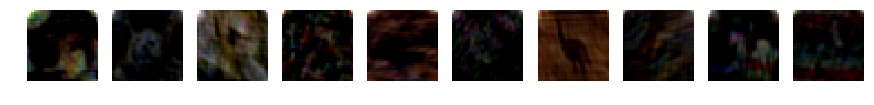

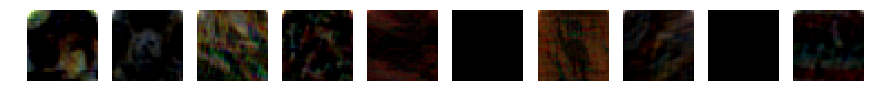

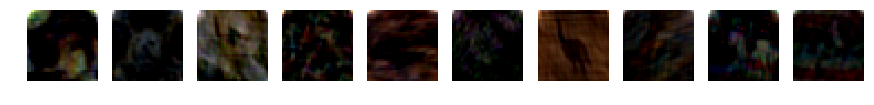

In [24]:
visualize(clean_reg[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-test-cifar10_l0')
visualize(clean_cwl0_iht[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl0-clean-cifar10_l0-iht')
visualize(clean_jsma_iht[x_vis].reshape(-1,*input_shape), 10, '../figures/jsma-clean-cifar10_l0-iht')

In [25]:
print ('Model Accuracy Reconstructed CW-l0: %.5f' % (model.model.evaluate(clean_cwl0_iht,model.test_labels[test_indices])[1]))
print ('Model Accuracy Reconstructed JSMA: %.5f' % (model.model.evaluate(clean_jsma_iht,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 1s 706us/step
Model Accuracy Reconstructed CW-l0: 0.38600
1000/1000 [==============================] - 0s 175us/step
Model Accuracy Reconstructed JSMA: 0.72300


In [26]:
D = get_matrix(n*n)
A = np.concatenate((D.T,np.identity(n*n)),axis=1)

In [27]:
#%%capture thirteen
#Reconstruct CW-l0
clean_cwl0_socp = np.zeros(cwl0_data.shape)
for i in range(num_test_samples):
    x_adv_r = cwl0_data[i,:,:,0].flatten()
    x_adv_g = cwl0_data[i,:,:,1].flatten()
    x_adv_b = cwl0_data[i,:,:,2].flatten()
    
    x_hat_orig_r = dct(reg_data[i,:,:,0].flatten(),norm='ortho')
    x_hat_orig_g = dct(reg_data[i,:,:,1].flatten(),norm='ortho')
    x_hat_orig_b = dct(reg_data[i,:,:,2].flatten(),norm='ortho')

  
    x_top_r,x_bot_r = get_top_bot_k_vec(x_hat_orig_r,k=75)
    x_top_g,x_bot_g = get_top_bot_k_vec(x_hat_orig_g,k=75)
    x_top_b,x_bot_b = get_top_bot_k_vec(x_hat_orig_b,k=75)

    eta_r = np.linalg.norm(x_bot_r)/2.0
    eta_g = np.linalg.norm(x_bot_g)/2.0
    eta_b = np.linalg.norm(x_bot_b)/2.0

    print(eta_r,eta_g,eta_b)
    print(np.linalg.norm(x_adv_r - reg_data[i,:,:,0].flatten()),np.linalg.norm(x_adv_g - reg_data[i,:,:,1].flatten()),np.linalg.norm(x_adv_b - reg_data[i,:,:,2].flatten()) )

    x_hat_r = socp(x_adv_r,A, n=n*n*2,eta=eta_r)[:n*n]
    x_hat_g = socp(x_adv_g,A, n=n*n*2,eta=eta_g)[:n*n]
    x_hat_b = socp(x_adv_b,A, n=n*n*2,eta=eta_b)[:n*n]
    x_hat_top_r,_ = get_top_bot_k_vec(x_hat_r,k=75)
    x_hat_top_g,_ = get_top_bot_k_vec(x_hat_g,k=75)
    x_hat_top_b,_ = get_top_bot_k_vec(x_hat_b,k=75)
    clean_cwl0_socp[i,:,:,0]= idct(x_hat_top_r.flatten(),norm='ortho').reshape(n,n)
    clean_cwl0_socp[i,:,:,1]= idct(x_hat_top_g.flatten(),norm='ortho').reshape(n,n)
    clean_cwl0_socp[i,:,:,2]= idct(x_hat_top_b.flatten(),norm='ortho').reshape(n,n)

6.172527242484648 5.065662388413783 5.153267325715798
0.0 0.0 0.0
4.723153028732245 4.716662270441409 4.866064349725186
2.8885534 2.635971 2.2905474
4.177111483760896 3.554419218951638 3.790258762667109
0.0 0.0 0.0
6.940833007594955 3.9288113703759757 3.05781255964872
6.9853315 3.0422673 1.4892746
4.11382045466281 3.8720826955716845 4.412506855836875
4.6283774 3.9004042 3.5560067
5.62306109443717 4.543146672266888 3.899500533957093
5.643449 3.5141628 0.67179507
5.946246924576513 2.8261676719176063 3.172358866966103
6.055719 1.5434301 1.5907944
10.63583173817709 11.624896614587028 7.235940224214007
11.072425 11.713962 8.103779
5.808569883407994 5.776158885074173 5.82133533908854
2.8385274 2.574824 2.0190725
2.5495112389503976 2.586927375407675 2.5719618266849915
0.0 0.0 0.0
2.5994761268898015 2.7191409618714713 3.066892395055082
0.87233984 0.44485813 0.5910081
4.547094295209954 4.492136822876021 5.768260098916427
4.564391 4.362853 4.981271
8.368667189506855 3.7619862217066578 2.51573243

5.041856499445425 5.107388235696923 5.200032331356879
0.0 0.0 0.0
5.925603736919771 5.8529512570384 5.821435706582578
4.7660375 4.2802467 3.6128864
6.517975955487816 6.671357405633213 6.77353235586097
5.5607677 5.718442 5.693145
4.9719085178070435 5.1091794649508735 4.995832466903506
0.0 0.0 0.0
4.6044210805592245 4.479344775279081 4.961009006865578
0.0 0.0 0.0
5.762779997383546 5.634412772166891 5.646744475723592
0.0 0.0 0.0
5.098323853324463 5.324255291613203 5.469019362176747
5.5178947 5.28935 4.874983
4.601671961301727 4.120348793677926 4.92965558907906
5.042921 5.4371567 4.604363
5.029691159440905 4.8468953536840775 4.922301976639237
3.4389603 2.993581 2.5214052
4.862236240216032 3.912881357313008 3.774867554557885
5.5331554 2.3325665 1.9858614
4.494921596914203 4.206643937253148 4.774739994200317
0.0 0.0 0.0
3.7391357860254213 3.8015257796617954 5.089860103721446
3.3698988 3.0173202 4.131404
4.221859020467073 4.215755078485138 4.295919512037742
3.1777015 2.8975184 2.5053246
6.176

7.005981811652611 6.44154208772859 5.542121481871336
3.6259942 5.1917634 5.0768547
3.302450158286509 3.4047317798424137 3.8102548145507997
0.0 0.0 0.0
5.910562600013468 7.284593137883743 6.7096396869346995
0.0 0.0 0.0
4.560599810753743 4.685556324162499 4.459280897338031
0.0 0.0 0.0
5.117676405871273 5.268346442562471 5.653491948491779
0.0 0.0 0.0
3.2693886655592026 3.3750796598010995 3.5004686763514434
4.416259 4.496963 4.610942
5.3364908326710205 4.655193765037274 7.736309753928783
0.0 0.0 0.0
4.054508454587302 4.518317010710883 5.364362193061433
3.070723 3.3633912 4.7497807
5.302885497617555 5.701178393748238 4.821256110142361
6.700228 6.5695634 5.721375
4.746482684754931 6.04403638484693 6.977943089121648
0.0 0.0 0.0
5.775498306213737 6.090740365673902 6.263354344972215
4.7525516 5.461032 5.283827
4.188932683589717 4.628879604522144 5.560017846038165
3.0257502 4.0214963 6.4528933
6.9174829667382145 6.63912641702918 6.475671440422251
0.0 0.0 0.0
4.765740717628676 5.684641437325292 6

4.806243118665438 5.187811962750082 4.525332153552444
0.0 0.0 0.0
5.177610316549839 5.568894129181655 4.90145257234182
0.0 0.0 0.0
5.70680905195934 5.573576894755024 6.30340958435031
2.6688898 2.7332256 4.045341
3.613822598050493 4.440515564816544 5.2146188088724
2.3169425 2.672677 2.5342615
4.336391676220267 5.039122313961763 5.524212937633088
3.967201 3.7355635 3.166304
4.690105358474148 5.007586178718637 6.910370656667653
0.0 0.0 0.0
5.665775123216244 5.7191287521847265 5.11560495071736
0.0 0.0 0.0
7.303753285152167 7.961393206174334 7.647296403799516
8.089462 8.825982 8.561021
7.292881463902871 7.805923727353097 8.197972250216218
0.0 0.0 0.0
6.103875801171692 5.448007426262657 6.281876295311797
5.3154864 5.1091375 5.2858214
4.388187803221617 7.5201492929194815 9.308453326053034
4.655161 8.054083 9.759243
8.363718488946589 7.7087745046554765 6.380893538887749
0.0 0.0 0.0
3.240131598208365 3.295124726982827 5.2443845340043165
1.8561697 2.2240403 4.1990347
7.189965310934723 7.50232939

6.064232712834448 5.9042668467243455 5.342636614607079
6.8128285 6.5215287 5.71536
9.09151032472564 6.107335363794926 5.037046782595668
9.415445 6.3557005 5.1991134
6.555109366412175 8.222185680693109 9.695303934336602
0.0 0.0 0.0
6.104313674107024 4.071507403724642 4.017739854773095
6.057735 3.8012383 4.104414
5.607933352502961 5.831803407310344 6.05234975215748
5.9221683 5.9074597 6.2927003
5.411038670575929 6.9981354386026675 7.827916564547497
5.540361 7.4191957 8.074855
6.1460865237121824 5.970419788117558 5.856401114875
3.5447993 3.320537 5.2616324
3.685782549617874 3.655780767476198 4.90461611898602
4.162504 4.209343 5.663235
5.760637653317772 5.661277271723858 7.5627280386116595
0.0 0.0 0.0
4.870596729283728 4.9358063139174275 4.807799917230223
3.5674365 4.2765627 5.115881
4.46549327019398 6.071954528313338 8.413359134174852
4.8156037 6.395202 8.645181
3.8490834385192874 3.741091894386472 3.774338396852331
3.918283 3.399368 4.476314
2.998272747592253 3.2041818243711826 3.9337994

8.162675419194313 6.654191415712572 4.890236508028801
8.28181 6.5378113 3.5532796
3.7634997495114195 4.083964870527887 3.845725603808642
1.9278584 2.8165598 2.7031193
3.810856523157738 3.7859752660671937 3.8162646413237256
1.4900776 1.1909035 1.0089362
6.926917159613369 6.706711270129127 7.088228311558772
0.0 0.0 0.0
4.46861992000162 4.144568783363288 3.566069073178691
0.0 0.0 0.0
3.988778390120736 2.749923381784908 2.508460195237272
6.0970683 4.485227 2.328882
6.560664189187504 3.438926636022201 2.8752609230330517
7.421165 5.503889 4.2510915
4.984133589824159 4.029757948100451 2.666243467932049
3.432875 1.6934339 1.5812047
2.6618903047475153 2.6367979588338013 2.4811179946550603
4.171399 3.608698 3.2852287
2.1631492935366703 2.518667593332221 2.8715769779519893
1.4893352 1.6288812 1.27553
6.052048778314897 6.003279177479065 5.673798283810259
5.148689 4.607048 3.2733228
4.763762695073463 4.568770783852679 4.274461714062205
6.4072266 5.3722534 3.802585
6.646811718703775 6.32778248767596

In [ ]:
%%capture thirteen
#Reconstruct CW-l0
clean_jsma_socp = np.zeros(jsma_data.shape)
for i in range(num_test_samples):
    x_adv_r = jsma_data[i,:,:,0].flatten()
    x_adv_g = jsma_data[i,:,:,1].flatten()
    x_adv_b = jsma_data[i,:,:,2].flatten()
    
    x_hat_orig_r = dct(reg_data[i,:,:,0].flatten(),norm='ortho')
    x_hat_orig_g = dct(reg_data[i,:,:,1].flatten(),norm='ortho')
    x_hat_orig_b = dct(reg_data[i,:,:,2].flatten(),norm='ortho')

  
    x_top_r,x_bot_r = get_top_bot_k_vec(x_hat_orig_r,k=75)
    x_top_g,x_bot_g = get_top_bot_k_vec(x_hat_orig_g,k=75)
    x_top_b,x_bot_b = get_top_bot_k_vec(x_hat_orig_b,k=75)

    eta_r = np.linalg.norm(x_bot_r)/2.0
    eta_g = np.linalg.norm(x_bot_g)/2.0
    eta_b = np.linalg.norm(x_bot_b)/2.0

    x_hat_r = socp(x_adv_r,A, n=n*n*2,eta=eta_r)[:n*n]
    x_hat_g = socp(x_adv_g,A, n=n*n*2,eta=eta_g)[:n*n]
    x_hat_b = socp(x_adv_b,A, n=n*n*2,eta=eta_b)[:n*n]
    x_hat_top_r,_ = get_top_bot_k_vec(x_hat_r,k=75)
    x_hat_top_g,_ = get_top_bot_k_vec(x_hat_g,k=75)
    x_hat_top_b,_ = get_top_bot_k_vec(x_hat_b,k=75)
    clean_jsma_socp[i,:,:,0]= idct(x_hat_top_r.flatten(),norm='ortho').reshape(n,n)
    clean_jsma_socp[i,:,:,1]= idct(x_hat_top_g.flatten(),norm='ortho').reshape(n,n)
    clean_jsma_socp[i,:,:,2]= idct(x_hat_top_b.flatten(),norm='ortho').reshape(n,n)